In [1]:
import gc
import os
import glob
import zipfile
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
import PIL
from PIL import ImageOps, ImageFilter, ImageDraw

In [2]:
DATA_PATH = '../input/2019-3rd-ml-month-with-kakr/'
os.listdir(DATA_PATH)

['train',
 'test',
 'train.csv',
 'sample_submission.csv',
 'test.csv',
 'class.csv']

In [3]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

In [4]:
def crop_boxing_img(img_name, margin=16) :
    if img_name.split('_')[0] == "train" :
        PATH = TRAIN_IMG_PATH
        data = df_train
    elif img_name.split('_')[0] == "test" :
        PATH = TEST_IMG_PATH
        data = df_test
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1,y1,x2,y2))

In [5]:
for i, row in df_train.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    cropped.save(row['img_file'])
print('over')

over


In [6]:
for i, row in df_test.iterrows():
    cropped = crop_boxing_img(row['img_file'])
    cropped.save(row['img_file'])
print("over")

over


../input/2019-3rd-ml-month-with-kakr/train/train_00101.jpg
train_00101.jpg
../input/2019-3rd-ml-month-with-kakr/train/train_00102.jpg
train_00102.jpg
../input/2019-3rd-ml-month-with-kakr/train/train_00103.jpg
train_00103.jpg
../input/2019-3rd-ml-month-with-kakr/train/train_00104.jpg
train_00104.jpg
../input/2019-3rd-ml-month-with-kakr/train/train_00105.jpg
train_00105.jpg


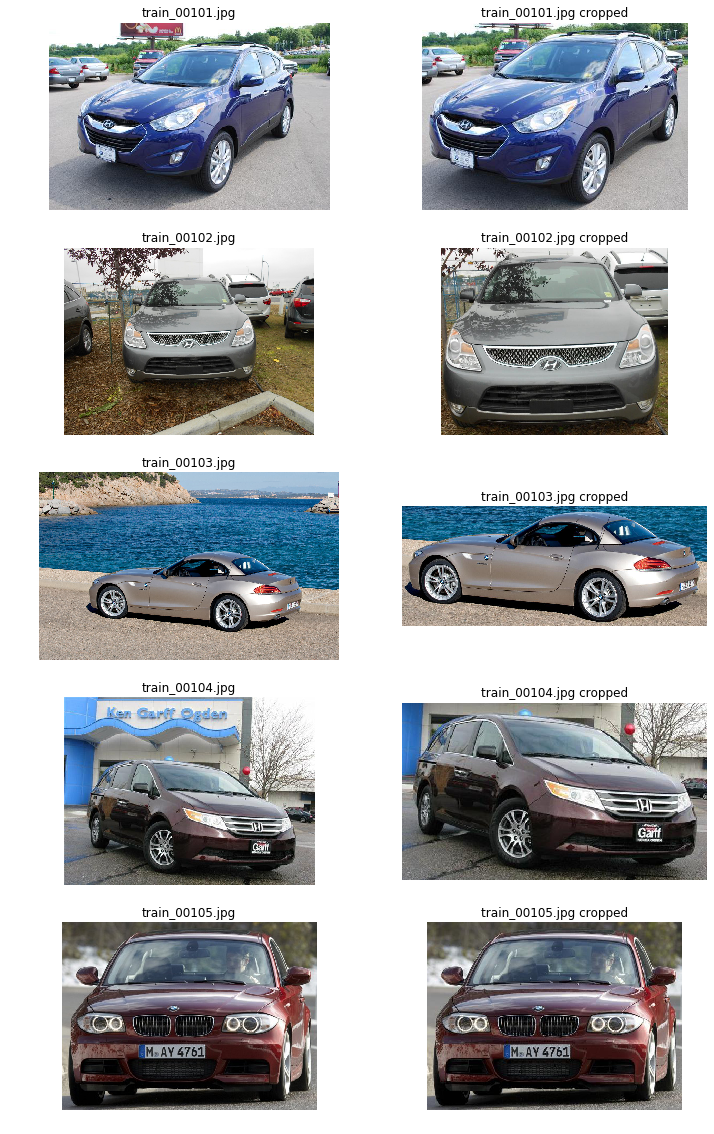

In [7]:
tmp_imgs = df_train['img_file'][100:105]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    print(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, 2*num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')
    
    img_crop = PIL.Image.open(f_name)
    print(f_name)
    plt.subplot(5, 2, 2*num + 2)
    plt.title(f_name + ' cropped')
    plt.imshow(img_crop)
    plt.axis('off')

In [8]:
from sklearn.model_selection import train_test_split

df_train["class"] = df_train["class"].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)


(8012, 2)
(2004, 2)
(6169, 1)


In [9]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

img_size_224=(224,224)
img_size_299=(299,299)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 20
batch_size_32 = 32
batch_size_20=20
# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = True, 
    vertical_flip = False,
    zoom_range=0.10,
    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train, 
    directory='',
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size_224,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size_32,
    seed=42
)


test_generator_299 = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory='',
    x_col='img_file',
    y_col=None,
    target_size= img_size_299,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size_32,
    shuffle=False
)
test_generator_224 = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory='',
    x_col='img_file',
    y_col=None,
    target_size= img_size_224,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size_20,
    shuffle=False
)

Using TensorFlow backend.


Found 8012 validated image filenames belonging to 196 classes.
Found 6169 validated image filenames.
Found 6169 validated image filenames.


In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D
from keras import optimizers
def get_model(application, size):
    base_model = application(weights='imagenet', input_shape=(size,size,3), include_top=False)
    #base_model.trainable = False
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(196, activation='softmax'))
    model.summary()

    optimizer = optimizers.RMSprop(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

    return model

In [11]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else :
        return num_samples // batch_size

In [12]:
from keras.models import load_model
from keras.applications.xception import Xception, decode_predictions
from keras.applications.densenet import DenseNet201, decode_predictions
from keras.applications.inception_v3 import InceptionV3, decode_predictions
model_xception = get_model(Xception, 299)
model_xception.load_weights('../input/kaggle2936/xception_weights2.h5')
xception_predict = model_xception.predict_generator(
    generator=test_generator_299,
    steps = get_steps(nb_test_samples,32),
    verbose=1
)

83689472/83683744 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 196)               200900    
Total params: 23,160,556
Trainable params: 23,106,028
Non-trainable params: 54,528
_________________________________________________________________
193/193 [==============================] - 48s 250ms/step


In [13]:
model_inception = get_model(InceptionV3, 299)
model_inception.load_weights('../input/kaggle9526/inception_weights2.h5')
inception_predict = model_inception.predict_generator(
    generator=test_generator_299,
    steps = get_steps(nb_test_samples,32),
    verbose=1
)

87916544/87910968 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 196)               200900    
Total params: 24,101,860
Trainable params: 24,067,428
Non-trainable params: 34,432
_________________________________________________________________
193/193 [==============================] - 43s 223ms/step


In [14]:
model_DenseNet201 = get_model(DenseNet201, 224)
model_DenseNet201.load_weights('../input/kaggle2936/densenet201_weights.h5')
DenseNet201_predict = model_DenseNet201.predict_generator(
    generator=test_generator_224,
    steps = get_steps(nb_test_samples, batch_size_20),
    verbose=1
)

74842112/74836368 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1920)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1967104   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 196)               200900    
Total params: 20,489,988
Trainable params: 20,260,932
Non-trainable params: 229,056
_________________________________________________________________
309/309 [==============================] - 47s 152ms/step


In [15]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')


In [16]:
preds = DenseNet201_predict*0.35 + xception_predict*0.35+inception_predict*0.3
preds_class_indices=np.argmax(preds, axis=1)
preds_labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in preds_labels.items())
final_predictions = [labels[k] for k in preds_class_indices]

In [17]:

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission["class"] = final_predictions
submission.to_csv("submission.csv", index=False)
submission.head()


,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,94
4,test_00005.jpg,18


In [18]:
!rm -rf *.jpg

In [19]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv